## Import neccessary libraries

In [1]:
import shutil

import glob
import numpy as np
import cv2
import os
import sys
from skimage.metrics import structural_similarity as ssim
from PIL import Image
from numpy import genfromtxt
import random as rd
from skimage.morphology import erosion, dilation, opening, black_tophat, skeletonize, convex_hull_image
from skimage.util import img_as_ubyte
from skimage.morphology import disk  # noqa
from numpy import genfromtxt



from matplotlib.pyplot import imread
from imageio import imwrite
#from matplotlib.pyplot import imshow

%matplotlib inline

import matplotlib.pyplot as plt

## Get rid of incomplete gait cycle list

### Get rid of probe sets and gallary sets (if exists)

In [4]:
pre_path = "OULP-C1V2_Pack/Preprocess/" #Preprocess path of data

lst_num = [1,3,5,8,10,13,15,18,20,23,25,28,30]

for num in lst_num:
    folder = "OULP_GEI_(224x224)_{}f".format(num)

    path1 = pre_path + folder + "/Seq00"
    path2 = pre_path + folder + "/Seq01"
    for subject_dir in os.listdir(path1):
        subject_path1 = os.path.join(path1, subject_dir)
        subject_path2 = os.path.join(path2, subject_dir)
        if len(os.listdir(subject_path)) != 4:
            shutil.rmtree('{}'.format(subject_path1))
            shutil.rmtree('{}'.format(subject_path2))
        
        
    

    


    

## We will enhance the original image from the data 224x224 for more details

   Let take the example of Normalized Silhouettes randomly images

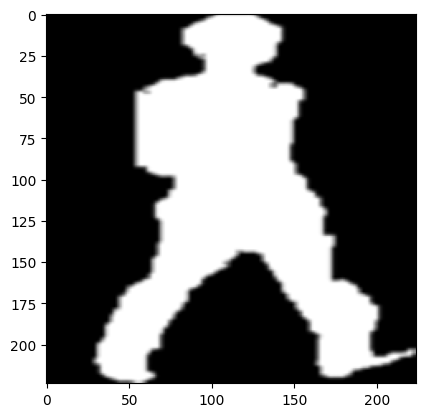

In [2]:
img = cv2.imread('OULP-C1V2_Pack/OULP-C1V2_NormalizedSilhouette(224x224)/Seq00/0000000/00000018.png', cv2.IMREAD_GRAYSCALE)
#gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img, cmap="gray")
plt.show()




Second argument is a flag which specifies the way image should be read.

* cv2.IMREAD_COLOR : Loads a color image. Any transparency of image will be neglected. It is the default flag.
* cv2.IMREAD_GRAYSCALE : Loads image in grayscale mode
* cv2.IMREAD_UNCHANGED : Loads image as such including alpha channel

As you can see that there are many noise point in that image and we want to reduce to enhance bettter image quality

### Therefore, Our Solution is the morphological opening on a human silhouette image using scikit-learn library

$$A \circ B = (A \ominus B) \oplus B  $$

Where $A$ is the image, $B$ is the structure element

In [2]:
def plot_comparison(original, filtered, original_name, filter_name):

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title(original_name)
    ax1.axis('off')
    ax2.imshow(filtered, cmap=plt.cm.gray)
    ax2.set_title(filter_name)
    ax2.axis('off')

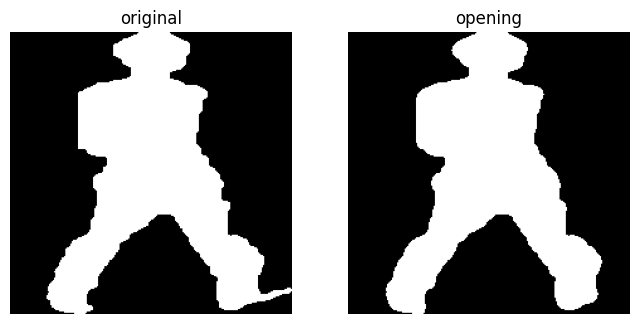

In [18]:
footprint = disk(6)
opened = opening(img, footprint)
plot_comparison(img, opened, 'original' ,'opening')

So, we can see that noise point has been reduced significantly, which is facilitating for next purpose of model, but there's little noise point, so we use medianBlur to do

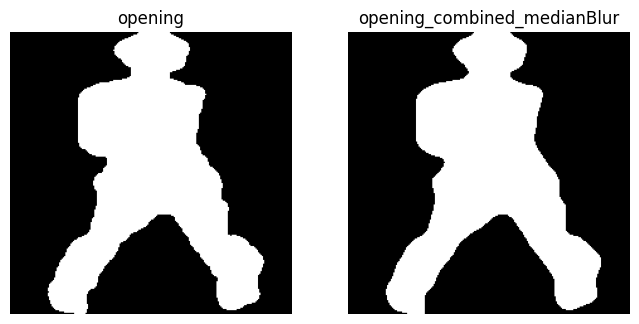

In [28]:
opened_medianBlur = cv2.medianBlur(opened, 9)
for i in range(opened_medianBlur.shape[0]):
    for j in range(opened_medianBlur.shape[1]):
        if opened_medianBlur[i][j] < 100:
            opened_medianBlur[i][j] = 0
        else:
            opened_medianBlur[i][j] = 255
plot_comparison(opened, opened_medianBlur, 'opening', 'opening_combined_medianBlur')


Sound Look Better

## We defined the function "path_open"

In [3]:
class Path_open:
    def __init__(self,path_subject):
        self.PathSubject = path_subject
        self.image_list = None
    def generate_image_list(self):
        csv_file = genfromtxt(self.PathSubject, delimiter = ",", dtype = np.int32)
        for subject in csv_file:
            subject_dir = str(subject[0])
            if len(subject_dir) != 7:
                subject_dir = '0' * (7 - len(subject_dir)) + subject_dir
                
            yield (subject_dir)
    def exe(self):
        self.image_list = list(self.generate_image_list())
    def save_path(self, type, fol, img_name, img_nparr):
        output_dir = 'OULP-C1V2_Pack/OULP-C1V2_NormalizedSilhouette(224x224)_openMedianBlur'
        self.check_fol_224(output_dir, type, fol)
        if os.path.isdir(os.path.join(output_dir, type, fol)):
            cv2.imwrite("{}/{}/{}/{}.png".format(output_dir,type, fol,img_name),img_nparr)
    def check_fol_224(self,output_dir, type,Folder):
        if os.path.exists(output_dir + "/" + type + "/" + Folder) == False:
            os.makedirs(os.path.join(output_dir, type, Folder))
        


In [ ]:
class Path_gallery_open(Path_open):
    def __init__(self, path, path_sub):
        super().__init__(path_sub)
        self.path = path
    def exe_path(self):
        super().exe()
        IDList_A_55_gallery = genfromtxt(self.PathSubject, delimiter = ",", dtype = np.int32)
        path_ = self.path + "/Seq00"

        for num in range(len(IDList_A_55_gallery)):
            Folder = self.image_list[num]
            print("This is the {}'th folder".format(Folder))
            self.check_img_224_gallery(path_, Folder)
            P = path_ + "/" + Folder + "/*.png"
            _P = glob.glob(P)
            footprint = disk(6)
            for img in _P:
                _img = cv2.imread(img,cv2.IMREAD_GRAYSCALE)
                opened = opening(_img, footprint)
                opened_medianBlur = cv2.medianBlur(opened, 9)
                for i in range(opened_medianBlur.shape[0]):
                    for j in range(opened_medianBlur.shape[1]):
                        if opened_medianBlur[i][j] < 100:
                            opened_medianBlur[i][j] = 0
                        else:
                            opened_medianBlur[i][j] = 255
                super().save_path("Seq00",Folder,img[-12:-4],opened_medianBlur)
                print("Convert successfully !!!!")
    def check_img_224_gallery(self, path, folder):
        data_dir = 'OULP-C1V2_Pack/OULP-C1V2_NormalizedSilhouette(88x128)/Seq00'
        folder = str(folder)
        for img in os.listdir(path + "/" + folder):
            _path_img = path + "/" + folder + "/" + img
            image = cv2.imread(_path_img)
            if image is None:
                _data_dir = data_dir + "/" + folder + "/" + img
                _image = Image.open(_data_dir)
                _image = _image.resize((224, 224))  
                _image = np.array(_image)
                cv2.imwrite(_path_img,_image)
a = Path_gallery_open("OULP-C1V2_Pack/OULP-C1V2_NormalizedSilhouette(224x224)","OULP-C1V2_Pack/OULP-C1V2_Subject_IDList/IDList_OULP-C1V2-A-55_Gallery.csv")

a.exe_path()

This is the 0000024'th folder
Convert successfully !!!!
Convert successfully !!!!
Convert successfully !!!!
Convert successfully !!!!
Convert successfully !!!!
Convert successfully !!!!
Convert successfully !!!!
Convert successfully !!!!
Convert successfully !!!!
Convert successfully !!!!
Convert successfully !!!!
Convert successfully !!!!
Convert successfully !!!!
Convert successfully !!!!
Convert successfully !!!!
Convert successfully !!!!
Convert successfully !!!!
Convert successfully !!!!
Convert successfully !!!!
Convert successfully !!!!
Convert successfully !!!!
Convert successfully !!!!
Convert successfully !!!!
Convert successfully !!!!
Convert successfully !!!!
Convert successfully !!!!
Convert successfully !!!!
Convert successfully !!!!
Convert successfully !!!!
Convert successfully !!!!
Convert successfully !!!!
Convert successfully !!!!
Convert successfully !!!!
Convert successfully !!!!
Convert successfully !!!!
Convert successfully !!!!
Convert successfully !!!!
Convert 

In [ ]:
class Path_probe_open(Path_open):
    def __init__(self, path, path_sub):
        super().__init__(path_sub)
        self.path = path
    def exe_path(self):
        super().exe()
        IDList_A_55_gallery = genfromtxt(self.PathSubject, delimiter = ",", dtype = np.int32)
        path_ = self.path + "/Seq01"

        for num in range(len(IDList_A_55_gallery)):
            Folder = self.image_list[num]
            print("This is the {}'th folder".format(Folder))
            self.check_img_224_probe(path_, Folder)
            P = path_ + "/" + Folder + "/*.png"
            _P = glob.glob(P)
            footprint = disk(6)
            for img in _P:
                _img = cv2.imread(img,cv2.IMREAD_GRAYSCALE)
                opened = opening(_img, footprint)
                opened_medianBlur = cv2.medianBlur(opened, 9)
                for i in range(opened_medianBlur.shape[0]):
                    for j in range(opened_medianBlur.shape[1]):
                        if opened_medianBlur[i][j] < 100:
                            opened_medianBlur[i][j] = 0
                        else:
                            opened_medianBlur[i][j] = 255
                super().save_path("Seq01",Folder,img[-12:-4],opened_medianBlur)
                print("Convert successfully !!!!")
    def check_img_224_probe(self, path, folder):
        data_dir = 'OULP-C1V2_Pack/OULP-C1V2_NormalizedSilhouette(88x128)/Seq01'
        folder = str(folder)
        for img in os.listdir(path + "/" + folder):
            _path_img = path + "/" + folder + "/" + img
            image = cv2.imread(_path_img)
            if image is None:
                _data_dir = data_dir + "/" + folder + "/" + img
                _image = Image.open(_data_dir)
                _image = _image.resize((224, 224))  
                _image = np.array(_image)
                cv2.imwrite(_path_img,_image)
b = Path_probe_open("OULP-C1V2_Pack/OULP-C1V2_NormalizedSilhouette(224x224)","OULP-C1V2_Pack/OULP-C1V2_Subject_IDList/demo_Probe_224.csv")

b.exe_path()

This is the 2000465'th folder
Convert successfully !!!!
Convert successfully !!!!
Convert successfully !!!!
Convert successfully !!!!
Convert successfully !!!!
Convert successfully !!!!
Convert successfully !!!!
Convert successfully !!!!
Convert successfully !!!!
Convert successfully !!!!
Convert successfully !!!!
Convert successfully !!!!
Convert successfully !!!!
Convert successfully !!!!
Convert successfully !!!!
Convert successfully !!!!
Convert successfully !!!!
Convert successfully !!!!
Convert successfully !!!!
Convert successfully !!!!
Convert successfully !!!!
Convert successfully !!!!
Convert successfully !!!!
Convert successfully !!!!
Convert successfully !!!!
Convert successfully !!!!
Convert successfully !!!!
Convert successfully !!!!
Convert successfully !!!!
Convert successfully !!!!
Convert successfully !!!!
Convert successfully !!!!
Convert successfully !!!!
Convert successfully !!!!
Convert successfully !!!!
Convert successfully !!!!
Convert successfully !!!!
Convert 

And we convert to 1f-GEI, 3f-GEI, ... The same as part 1